In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.tsa.stattools as sts
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('Cleaned_data.csv')

In [3]:
df.head()

,Production Date,Land Class,Land Category,State,County,FIPS Code,Offshore Region,Commodity,Disposition Code,Disposition Description,Volume
0,2015-01-01,Federal,Offshore,Offshore,Offshore,Offshore,Offshore Alaska,Gas (Mcf),1,Sales-Royalty Due-MEASURED,0.0
1,2015-01-01,Federal,Offshore,Offshore,Offshore,Offshore,Offshore Gulf,Gas (Mcf),1,Sales-Royalty Due-MEASURED,14508756.0
2,2015-01-01,Federal,Offshore,Offshore,Offshore,Offshore,Offshore Pacific,Gas (Mcf),1,Sales-Royalty Due-MEASURED,1207520.0
3,2015-01-01,Federal,Offshore,Offshore,Offshore,Offshore,Offshore Gulf,Gas (Mcf),4,Sales-Royalty Due-Not Measured,487324.0
4,2015-01-01,Federal,Offshore,Offshore,Offshore,Offshore,Offshore Pacific,Gas (Mcf),4,Sales-Royalty Due-Not Measured,114808.0


### Oil production data

In [4]:
df['Commodity'].value_counts()

Commodity
Gas (Mcf)    235415
Oil (bbl)    235415
Name: count, dtype: int64

In [5]:
df_oil = df[df['Commodity'] == 'Oil (bbl)'].copy()

In [6]:
df_oil.head()

,Production Date,Land Class,Land Category,State,County,FIPS Code,Offshore Region,Commodity,Disposition Code,Disposition Description,Volume
43,2015-01-01,Federal,Offshore,Offshore,Offshore,Offshore,Offshore Alaska,Oil (bbl),1,Sales-Royalty Due-MEASURED,54848.0
44,2015-01-01,Federal,Offshore,Offshore,Offshore,Offshore,Offshore Gulf,Oil (bbl),1,Sales-Royalty Due-MEASURED,34110265.0
45,2015-01-01,Federal,Offshore,Offshore,Offshore,Offshore,Offshore Pacific,Oil (bbl),1,Sales-Royalty Due-MEASURED,71204.0
46,2015-01-01,Federal,Offshore,Offshore,Offshore,Offshore,Offshore Gulf,Oil (bbl),4,Sales-Royalty Due-Not Measured,3278.0
47,2015-01-01,Federal,Offshore,Offshore,Offshore,Offshore,Offshore Pacific,Oil (bbl),4,Sales-Royalty Due-Not Measured,0.0


In [7]:
df_monthly_oil = df_oil.groupby('Production Date')['Volume'].sum().reset_index()

In [8]:
df_monthly_oil.head()

,Production Date,Volume
0,2015-01-01,67515553.0
1,2015-02-01,61664960.0
2,2015-03-01,66342950.0
3,2015-04-01,67719040.0
4,2015-05-01,66484591.0


In [9]:
df_monthly_oil['Production Date'].is_monotonic_increasing

True

### Save Monthly Oil Data

In [10]:
df_monthly_oil.to_csv('Monthly_oil_data.csv', index=False)

In [11]:
sts.adfuller(df_monthly_oil.Volume)

(np.float64(-1.344737549600928),
 np.float64(0.6084645921750879),
 5,
 119,
 {'1%': np.float64(-3.4865346059036564),
  '5%': np.float64(-2.8861509858476264),
  '10%': np.float64(-2.579896092790057)},
 np.float64(3777.3018223971494))

The Augmented Dickey–Fuller test indicates that the monthly oil production time series is non-stationary (p = 0.61), which is expected due to long-term production decline and structural effects. For baseline regression models, differencing was applied, while the LSTM model was trained on the original scaled series.

Oil production time series are inherently non-stationary due to decline behavior and operational changes. While classical models require stationarity, LSTM models can learn non-stationary patterns directly. I tested stationarity using the Augmented Dickey–Fuller test and applied differencing only for baseline regression models.

### Monthly Production Over Time

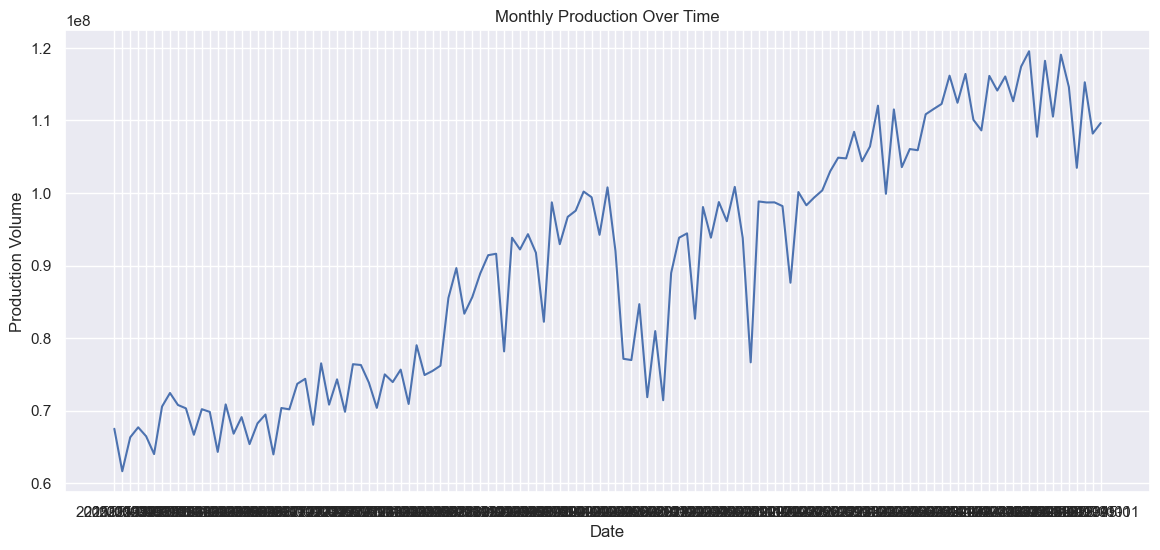

In [12]:
plt.figure(figsize=(14,6))
plt.plot(df_monthly_oil['Production Date'], df_monthly_oil['Volume'])
plt.title('Monthly Production Over Time')
plt.xlabel('Date')
plt.ylabel('Production Volume')
plt.show()

### Rolling average

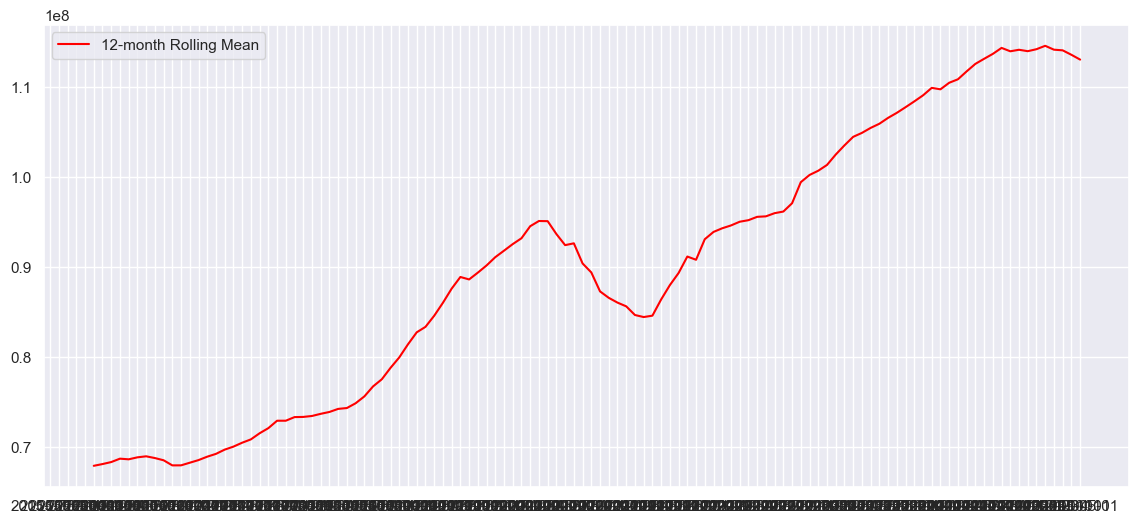

In [13]:
plt.figure(figsize=(14,6))
df_monthly_oil['rolling_12'] = df_monthly_oil['Volume'].rolling(12).mean()
plt.plot(df_monthly_oil['Production Date'], df_monthly_oil['rolling_12'], color='red', label='12-month Rolling Mean')
plt.legend()
plt.show()

In [14]:
df_monthly_oil.head()

,Production Date,Volume,rolling_12
0,2015-01-01,67515553.0,NaN
1,2015-02-01,61664960.0,NaN
2,2015-03-01,66342950.0,NaN
3,2015-04-01,67719040.0,NaN
4,2015-05-01,66484591.0,NaN


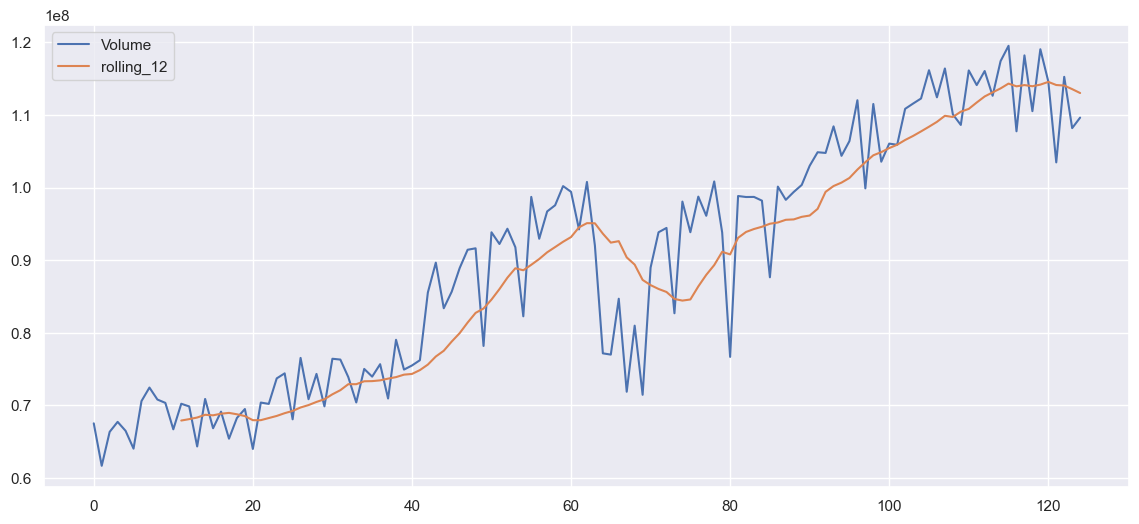

In [15]:
df_monthly_oil[['Volume', 'rolling_12']].plot(figsize=(14,6));

### Year over year production change

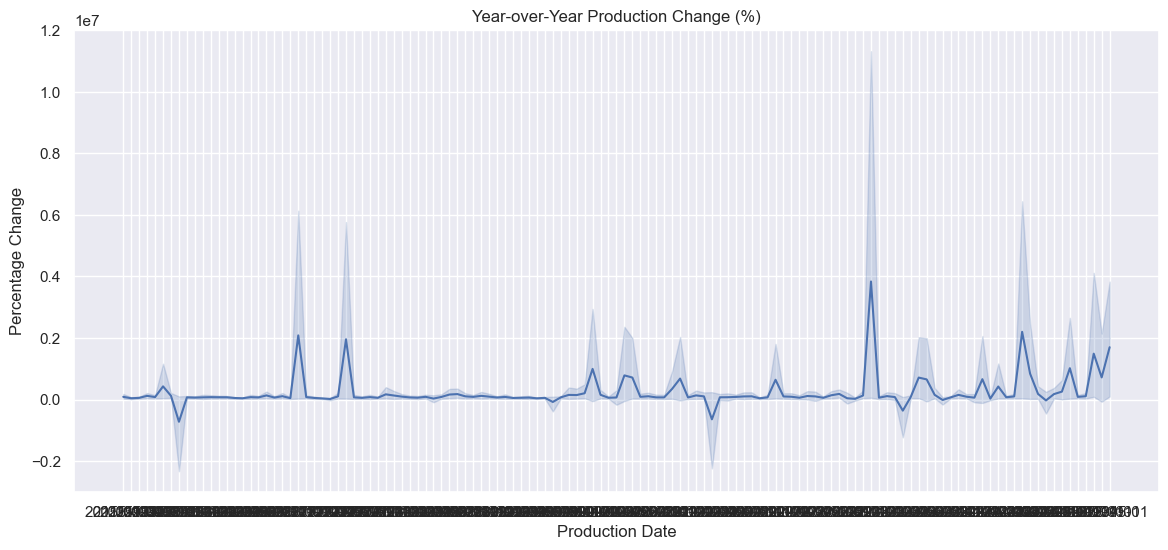

In [16]:
df['pct_change'] = df['Volume'].pct_change(periods=12) * 100
plt.figure(figsize=(14,6))
sns.lineplot(x='Production Date', y='pct_change', data=df)
plt.title('Year-over-Year Production Change (%)')
plt.ylabel('Percentage Change')
plt.show()

### Boxplot of Monthly Production Volume

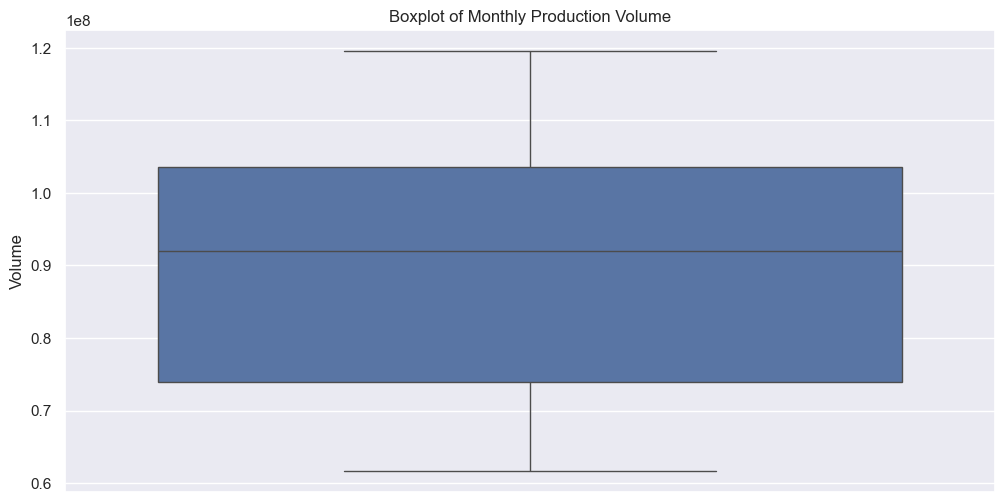

In [17]:
plt.figure(figsize=(12,6))
sns.boxplot(df_monthly_oil['Volume'])
plt.title('Boxplot of Monthly Production Volume')
plt.show()

### Seasonality

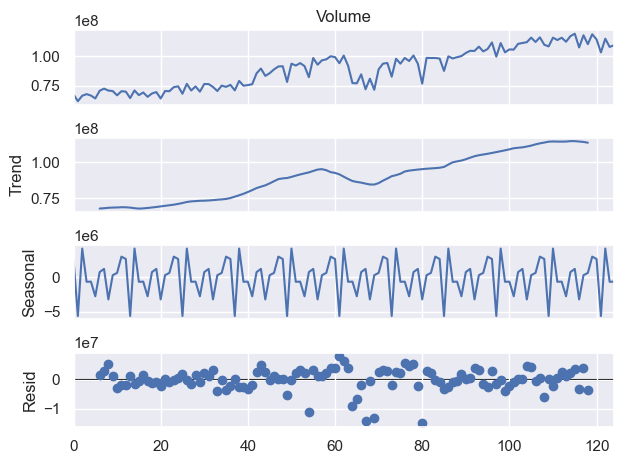

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_add = seasonal_decompose(df_monthly_oil['Volume'], model='additive', period=12)
decompose_result_add.plot()
plt.show()

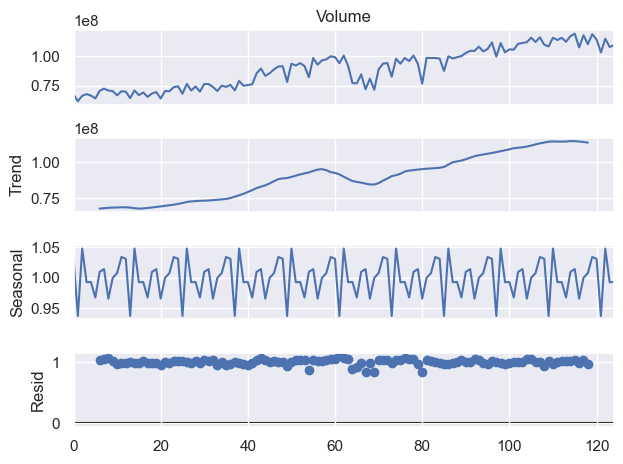

In [19]:
decompose_result_mult = seasonal_decompose(df_monthly_oil['Volume'], model='multiplicative', period=12)
decompose_result_mult.plot()
plt.show()

~ The residuals plot shows the unexplained component of production after removing trend and seasonality. Residuals appear mostly random, indicating that the additive decomposition captured the main patterns, with occasional spikes corresponding to operational anomalies.